Selected Folder: /Users/joschameiers/Desktop/Science & Work/Harvard/Virtual-Labbook_R-Space/Human-Microbiome-Extract-Library_Antibiotic-Activity-Screening/Antimicrobial Activity Assay/231212_E-coli_S-aureus_wellmate-no-seal_180rpm_40and40vs50_endpoint/input/input_ECwt
Folder already exists at /Users/joschameiers/Desktop/Science & Work/Harvard/Virtual-Labbook_R-Space/Human-Microbiome-Extract-Library_Antibiotic-Activity-Screening/Antimicrobial Activity Assay/231212_E-coli_S-aureus_wellmate-no-seal_180rpm_40and40vs50_endpoint/input/input_ECwt/output/
Readme file created at: /Users/joschameiers/Desktop/Science & Work/Harvard/Virtual-Labbook_R-Space/Human-Microbiome-Extract-Library_Antibiotic-Activity-Screening/Antimicrobial Activity Assay/231212_E-coli_S-aureus_wellmate-no-seal_180rpm_40and40vs50_endpoint/input/input_ECwt/output/README.txt
Quality control of transformed data (/Users/joschameiers/Desktop/Science & Work/Harvard/Virtual-Labbook_R-Space/Human-Microbiome-Extract-Library_Antibio

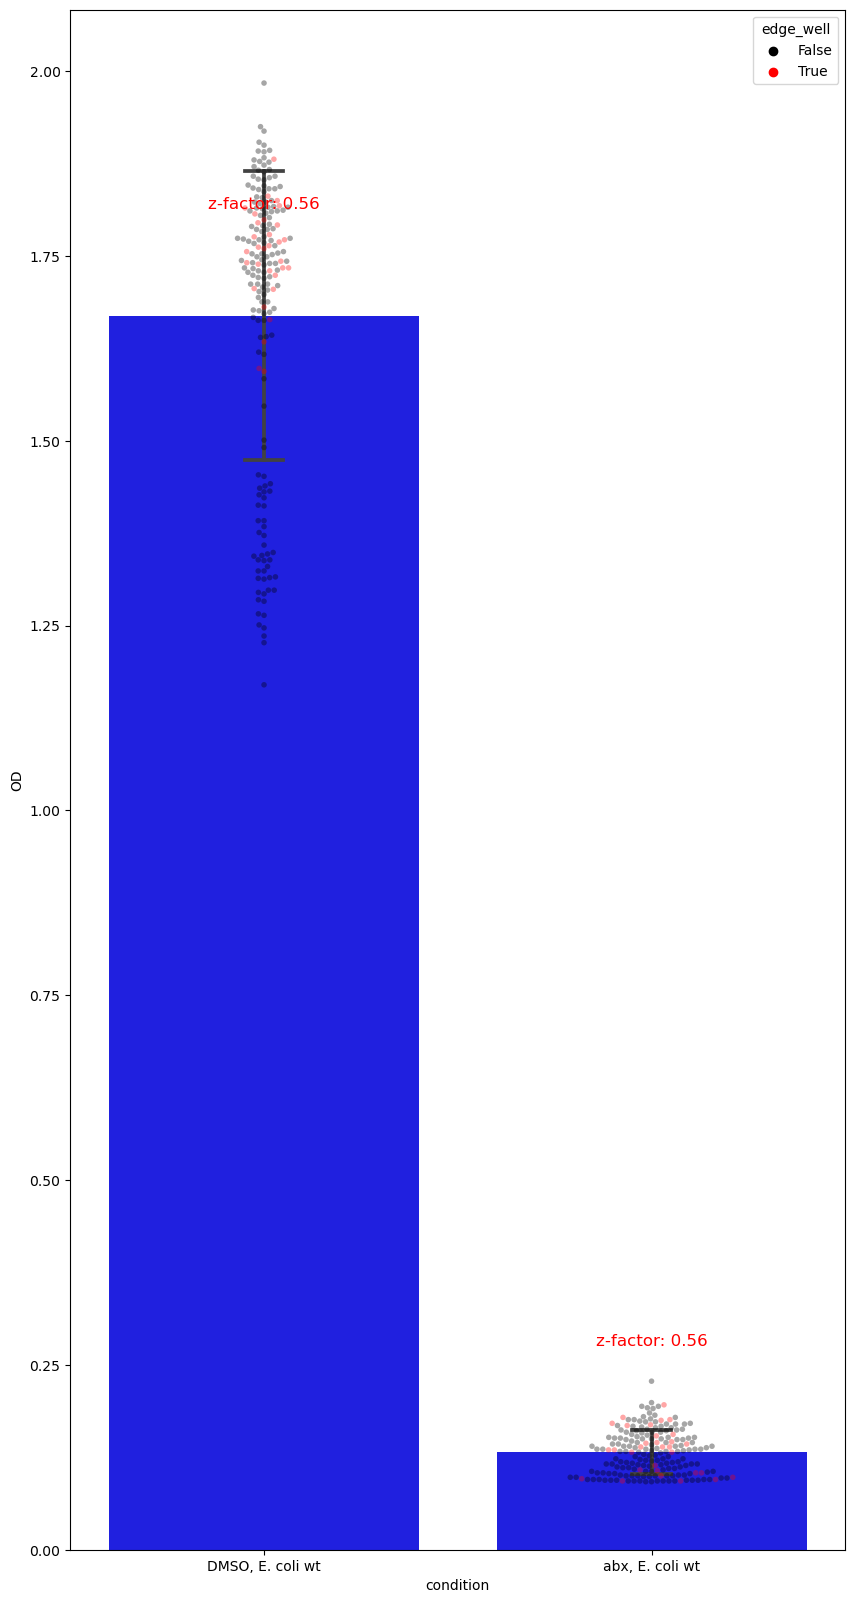

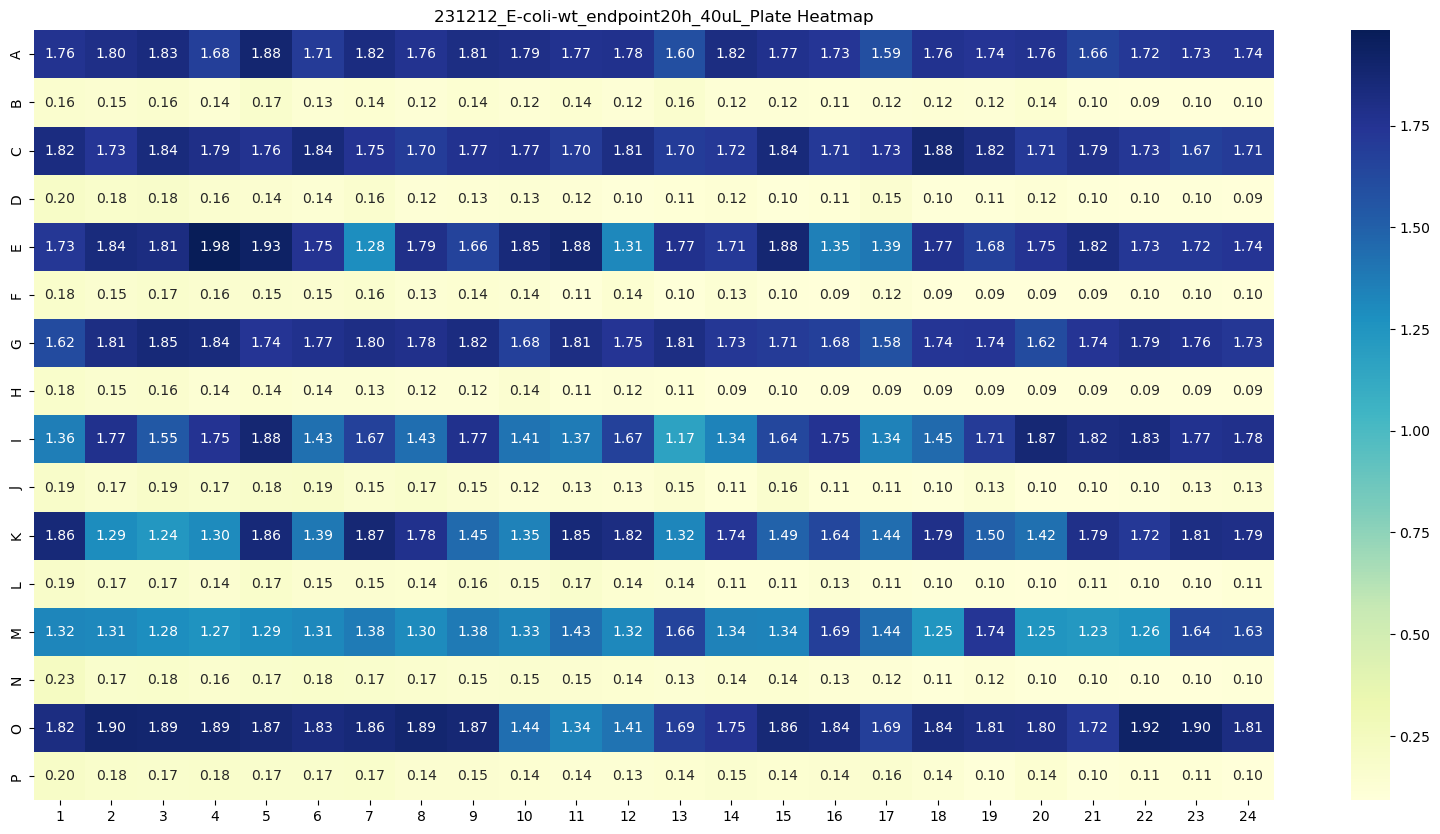

In [6]:
# this code can read data and metadata in 384-well format and do the math
# it also asks the user for the name of the data and metadata file names and names the output files accordingly
# this is basically a cleaned up version of v3.0
# + v3.2 can accept a whole input folder of .csv files.
# v3.3 shows bar plot + scatter plot that also marks edge wells red
# v3.4 allows you to run the script centrally and asks the user where the input folder is
# unfortunately, some comments got lost after modification by ChatGPT
# v3.5 expects a standard metadata file: abx or DMSO and calculates a z-factor for each strain on the plate
# this code is slightly less flexible regarding the metadata file: it expects "'condition', 'strain'" as input
# in the .csv for every well, e.g. "DMSO, E. coli wt" or "abx, MRSA"
# v3.6 also exports a readme-file with details on data input and output


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tkinter as tk
from tkinter import filedialog


def create_folder(input_path):
    input_path = input_path
    folder_path = input_path + "/output/"
    if not os.path.exists(folder_path):
        output_folder = os.makedirs(folder_path)
        print(f"Folder created at {folder_path}")
    else:
        print(f"Folder already exists at {folder_path}")
    return folder_path, input_path

def create_readme(folder_path, code_version):
    # this will create a readme-file that roughly explains how the data was transformed,
    # describes input expectation, which version of the code was used, and where the data was stored.
    readme_content = f"""README

- The code version used: {code_version}

Storage Information:
- The transformed data and output files are stored in the following directory:
  {folder_path}
"""
    readme_path = os.path.join(folder_path, 'README.txt')

    with open(readme_path, 'w') as readme_file:
        readme_file.write(readme_content)

    print(f'Readme file created at: {readme_path}')


def datafiles(input_path):
    # Get all CSV files in the specified folder excluding metadata.csv
    csv_files = [file for file in os.listdir(input_path) if file.endswith('.csv') and file != 'metadata.csv']
    return csv_files

def detect_delimiter(file_path):
    with open(file_path, 'r') as file:
        # Read only the first line to detect the delimiter
        # this code expects "condition, strain" as the argument of each well, so there naturally are ","
        # in any rows beyond the first 
        first_line = file.readline()
    
    # Check for the presence of common delimiters
    if ',' in first_line:
        return ','
    elif ';' in first_line:
        return ';'

def prepare_data(data_input):
    delimiter = detect_delimiter(data_input)
    data = pd.read_csv(data_input, sep=delimiter, index_col=0)
    data_T = data.T
    data_T = data_T.reset_index()
    data_T = data_T.rename(columns={'index': 'well'})
    data_T_melt = pd.melt(data_T, id_vars=['well'], var_name='OD')
    data_T_melt['well'] = data_T_melt['OD'] + data_T_melt['well']
    data_T_melt = data_T_melt[['well', 'value']]
    data_T_melt = data_T_melt.rename(columns={'value': 'OD'})
    print(f"Quality control of transformed data ({data_input}):\n")
    print(data_T_melt)
    return data_T_melt, data

def prepare_metadata(metadata_input):
    delimiter = detect_delimiter(metadata_input)
    metadata = pd.read_csv(metadata_input, sep=',', index_col=0)
    metadata_T = metadata.T
    meatadata_T = metadata_T.reset_index()
    metadata_T = meatadata_T.rename(columns={'index': 'well'})
    metadata_T_melt = pd.melt(metadata_T, id_vars=['well'], var_name='condition')
    metadata_T_melt['well'] = metadata_T_melt['condition'] + metadata_T_melt['well']
    metadata_T_melt = metadata_T_melt[['well', 'value']]
    metadata_T_melt = metadata_T_melt.rename(columns={'value': 'condition'})
    print(f"Quality control of transformed metadata ({metadata_input}):\n")
    print(metadata_T_melt)
    return metadata_T_melt

def merge(data, metadata, folder, data_name):
    merged_data = pd.merge(data, metadata, on='well')
    #merged_data = merged_data.drop("well", axis=1)
    merged_data = merged_data.sort_values(by='condition', ascending=False)
    merged_data.to_csv(os.path.join(folder, f'{data_name}_merged_data.csv'), index=False)
    print(f"Quality control of merged data ({data_name}_merged_data.csv):\n")
    print(merged_data)
    print(f"Saved at: {os.path.join(folder)}")
    return merged_data

def group_data(data_merged, folder, data_name):
    grouped_data = data_merged.groupby('condition').agg({'OD': ['mean', 'std']})
    grouped_data.reset_index(inplace=True)
    grouped_data.columns = ['condition', 'mean_OD', 'std_OD']
    
    # Separate treatment and strain
    grouped_data[['treatment', 'strain']] = grouped_data['condition'].str.split(', ', expand=True)

    # Pivot the DataFrame to have treatments as columns
    pivot_data = grouped_data.pivot(index='strain', columns='treatment', values=['mean_OD', 'std_OD'])

    # Extract mean and std for positive (abx) and negative (DMSO) controls
    mean_pos = pivot_data[('mean_OD', 'abx')]
    std_pos = pivot_data[('std_OD', 'abx')]
    mean_neg = pivot_data[('mean_OD', 'DMSO')]
    std_neg = pivot_data[('std_OD', 'DMSO')]

    # Calculate z-factors for each strain
    z_factors = 1 - (3 * (std_pos + std_neg) / abs(mean_neg - mean_pos))

    # Add z-factors to the grouped_data DataFrame
    grouped_data['z_factor'] = grouped_data.apply(lambda row: round(z_factors.loc[row['strain']], 2), axis=1)

    return grouped_data

def plot_BarGraph(data_grouped, data_merged, folder_path, data_name, fig_size_bar, dpi):
    col_one = ('B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'O1')
    # Determine if a well is at the edge
    data_merged['edge_well'] = data_merged['well'].apply(lambda x: x.startswith('A') or x.startswith('P') or x.endswith('24') or x == col_one)

    # Separate treatment and strain
    data_merged[['treatment', 'strain']] = data_merged['condition'].str.split(', ', expand=True)

    # Reset indices for both DataFrames
    data_grouped = data_grouped.reset_index(drop=True)
    data_merged = data_merged.reset_index(drop=True)
    
    print(f"Quality control of new merged data ({data_name}_merged_data.csv):\n")
    print(data_merged)

    # Create a figure with the specified size
    plt.figure(figsize=fig_size_bar)

    # Use Seaborn's barplot to create the bar graph with error bars
    #sns.barplot(x="condition", y="OD", data=data_merged, capsize=.1, errorbar='sd', color='blue')

    # Use Seaborn's barplot to create the bar graph with error bars
    sns.barplot(x="condition", y="OD", data=data_merged, capsize=.1, color='blue', errorbar='sd', order=data_grouped['condition'].unique())  # Set the order explicitly       
 
    
    # Use Seaborn's swarmplot to add swarm plot points
    #sns.swarmplot(x="condition", y="OD", data=data_merged, hue="edge_well", palette={False: '0', True: 'red'}, alpha=.35, size=4)

    # Use Seaborn's swarmplot to add swarm plot points
    sns.swarmplot(x="condition", y="OD", data=data_merged, hue="edge_well", palette={False: '0', True: 'red'}, alpha=.35, size=4, order=data_grouped['condition'].unique())  # Set the order explicitly

    
    # Annotate bars with z-factors
    for idx, bar in enumerate(plt.gca().patches[:min(len(data_grouped), len(data_merged))]):
        z_factor = data_grouped.loc[idx, 'z_factor']
        plt.gca().annotate(f'z-factor: {z_factor}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                           ha='center', va='center', xytext=(0, 80), textcoords='offset points', color='red', fontsize=12)       
        
    # Show the plot
    print("Quality control of mean, std., and z-factor (grouped_data):\n")
    print(data_grouped)
    data_grouped.to_csv(os.path.join(folder_path, f'{data_name}_grouped_data.csv'), index=False)
    print(f"Saved at: {os.path.join(folder_path)}")
    plt.savefig(os.path.join(folder_path, f'{data_name}_bar-graph.png'), dpi=dpi)
    plt.show()
    
def generate_heatmap(data, folder_path, data_name, fig_size_heat, dpi):
    plt.figure(figsize=fig_size_heat)
    sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True, square=False)
    plt.title(f'{data_name}_Plate Heatmap')
    plt.savefig(os.path.join(folder_path, f'{data_name}_heat-map.png'), dpi=dpi)
    plt.show()

def main():
    ############################
    ### update code version! ###
    code_version = "v3.6"    ###
    ### update code version! ###
    ############################
    
    # graph output size and resolution
    fig_size_bar = (10, 20)
    fig_size_heat = (20, 10)
    dpi = 300
    
    # Create the root window (it won't be shown)
    root = tk.Tk()
    root.withdraw()

    # Ask the user to choose a directory
    file_path = filedialog.askdirectory(title="Select Folder Containing CSV Files")

    # Display the chosen folder path
    print(f"Selected Folder: {file_path}")

    folder_path, input_path = create_folder(file_path)
    csv_files = datafiles(input_path)
    create_readme(folder_path, code_version)

    for csv_file in csv_files:
        data_T_melt, data = prepare_data(os.path.join(input_path, csv_file))
        metadata_T_melt = prepare_metadata(os.path.join(input_path, 'metadata.csv'))  # Assuming metadata.csv is fixed
        merged_data = merge(data_T_melt, metadata_T_melt, folder_path, csv_file[:-4])
        grouped_data = group_data(merged_data, folder_path, csv_file[:-4])
        plot_BarGraph(grouped_data, merged_data, folder_path, csv_file[:-4], fig_size_bar, dpi)
        generate_heatmap(data, folder_path, csv_file[:-4], fig_size_heat, dpi)

if __name__ == "__main__":
    main()
    